# 설비 이상을 조기에 예측하는 이상탐지 시스템

## 프로젝트 개요
이 시스템은 설비의 이상을 조기에 예측하여 유지보수와 리스크 관리에 중요한 역할을 합니다. 설비의 정상적인 동작을 기반으로 데이터를 수집하고, 이를 통해 예측 모델을 학습하여 이상 징후를 실시간으로 감지합니다.

## 데이터
- **측정 항목**: 역률 평균, 전압 고조파 평균, 전류 고조파 평균과 같은 설비 AIoT 센서 
- **라벨** : 시스템의 경고 상태(측정값의 상태를 기준으로 분류한 정상 상태와 경고 상태)

## 주요 목표
- 설비의 **이상탐지**를 통해 조기에 경고를 제공하기 위한 이상탐지 모델 연구
- **이상 기준**: 특정 패턴 발생 이후 고장이나 시스템 경고 상태가 되기 전, 비정상적인 패턴을 검출하여 시스템 경고 발생을 예측
- **모델 학습**: 다양한 시계열 데이터를 활용하여 예측 정확도 향상

## 주요 기능
- **이상 탐지**: 실시간으로 수집된 데이터를 기반으로 설비의 상태를 점검하고, 비정상적인 패턴을 탐지합니다.
- **예측 모델**: 학습된 모델을 사용하여 설비가 정상인지, 주의가 필요한 상태인지, 혹은 경고가 필요한지 판단합니다.
- **결과 제공**: 이상이 탐지되면 경고 알림을 발생시켜 빠르게 대처할 수 있도록 지원할 수 있게 기능화 시킬 수 있습니다.

###  전력 데이터 전처리: 주요 태스크 요약

### 1.  라이브러리 및 시각화 설정
- `matplotlib`, `seaborn`, `plotly`: 시각화 도구
- `pandas`, `numpy`, `json`: 데이터 처리
- `umap`: 차원 축소
- 한글 폰트 및 마이너스 기호 깨짐 방지 설정

---

### 2. 주요 컬럼 그룹 정의
- `volt_cols`: 전압 관련 변수
- `current_cols`: 전류 및 전력 관련 변수
- `powerfactor_cols`: 역률 관련 변수
- `others_col`: 누적 전력량, 온도, 주파수 등
- `cols`: 전체 사용 컬럼 리스트 구성

---

### 3. JSON 데이터 전처리 함수 (`make_df`)
- JSON 파일 로드 → DataFrame 변환
- `ITEM_NAME`을 컬럼으로 피벗
- `LABEL_NAME` 병합 및 컬럼 필터링
- `'주의'` 라벨을 `'경고'`로 통일

---

### 4. 훈련/테스트 데이터 로딩
```python
df = make_df(train_pth, cols)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import json

import plotly.graph_objects as go
import seaborn as sns
import pprint



plt.rc('font', family='NanumGothicCoding')
mpl.rcParams['axes.unicode_minus'] = False

volt_cols = [
    '상전압평균', 'R상전압', 'S상전압', 'T상전압',
    '선간전압평균', 'R상선간전압', 'S상선간전압', 'T상선간전압',
    '전압고조파평균', 'R상전압고조파', 'S상전압고조파', 'T상전압고조파'
]

current_cols = [
    '전류평균', 'R상전류', 'S상전류', 'T상전류',
    '전류고조파평균', 'R상전류고조파', 'S상전류고조파', 'T상전류고조파',
    '유효전력평균', 'R상유효전력', 'S상유효전력', 'T상유효전력',
    '무효전력평균', 'R상무효전력', 'S상무효전력', 'T상무효전력'
]

powerfactor_cols = [
    '역률평균', 'R상역률', 'S상역률', 'T상역률'
]

others_col = [
    '누적전력량', '온도', '주파수'
]

cols = ['TIMESTAMP','LABEL_NAME'] + volt_cols + current_cols + powerfactor_cols + others_col

def make_df(pth, cols) :
  
    with open(pth, encoding = 'utf-8-sig') as f : data = json.load(f)
    df = pd.DataFrame(data['data'])
    df_pivot = df.pivot_table(index='TIMESTAMP', columns='ITEM_NAME', values='ITEM_VALUE', aggfunc='first')
    df_label = df[['TIMESTAMP', 'LABEL_NAME']].drop_duplicates().set_index('TIMESTAMP')
    df = df_pivot.join(df_label, on='TIMESTAMP').reset_index()
    df = df[cols]
    df = df.rename(columns = {"LABEL_NAME" : 'label'})
    df.loc[df.label == '주의','label'] = '경고' 
    return df 

train_pth = 'data/training/Combined_LabelledData_297_전류고조파평균.json'
test_pth  = 'data/validation/Combined_LabelledData_297_전류고조파평균.json'


df = make_df(train_pth, cols)

In [7]:

pprint.pp(df.label.value_counts())

test = make_df(test_pth, cols)
test.label.value_counts()

pprint.pp(test.label.value_counts())

label
정상    35397
경고     4923
Name: count, dtype: int64
label
정상    3653
경고    2107
Name: count, dtype: int64


## 라벨 분포 시각화 (파이 차트)

이 코드는 전처리된 데이터프레임 `df`의 `label` 컬럼을 기준으로 정상(Normal)과 비정상(Abnormal) 라벨의 비율을 파이 차트로 시각화합니다.

### 주요 내용
- `label` 컬럼의 분포 비율 계산 (`value_counts()`)
- Plotly의 `Pie` 차트를 사용하여 시각화
- 중앙에 구멍이 있는 도넛 형태(`hole=0.3`)
- 시각적으로 구분되는 색상 및 어두운 테마 설정

### 시각화 특징
- 배경: 블랙 테마
- 폰트 색상: 흰색 (`font_color="white"`)
- 범례 제목 색상: 노란색
- 비율 정보만 표시 (`textinfo='percent'`)
- 상호작용 가능한 hover 정보 (`label + percent`)


In [8]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']
values = df['label'].value_counts()/df['label'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Facility Multivariate Time Series dataset",
    title_font_color="white",
    font_size = 30,
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
    width = 1000,
)
fig.show()

label
0    35397
1     4923
Name: count, dtype: int64


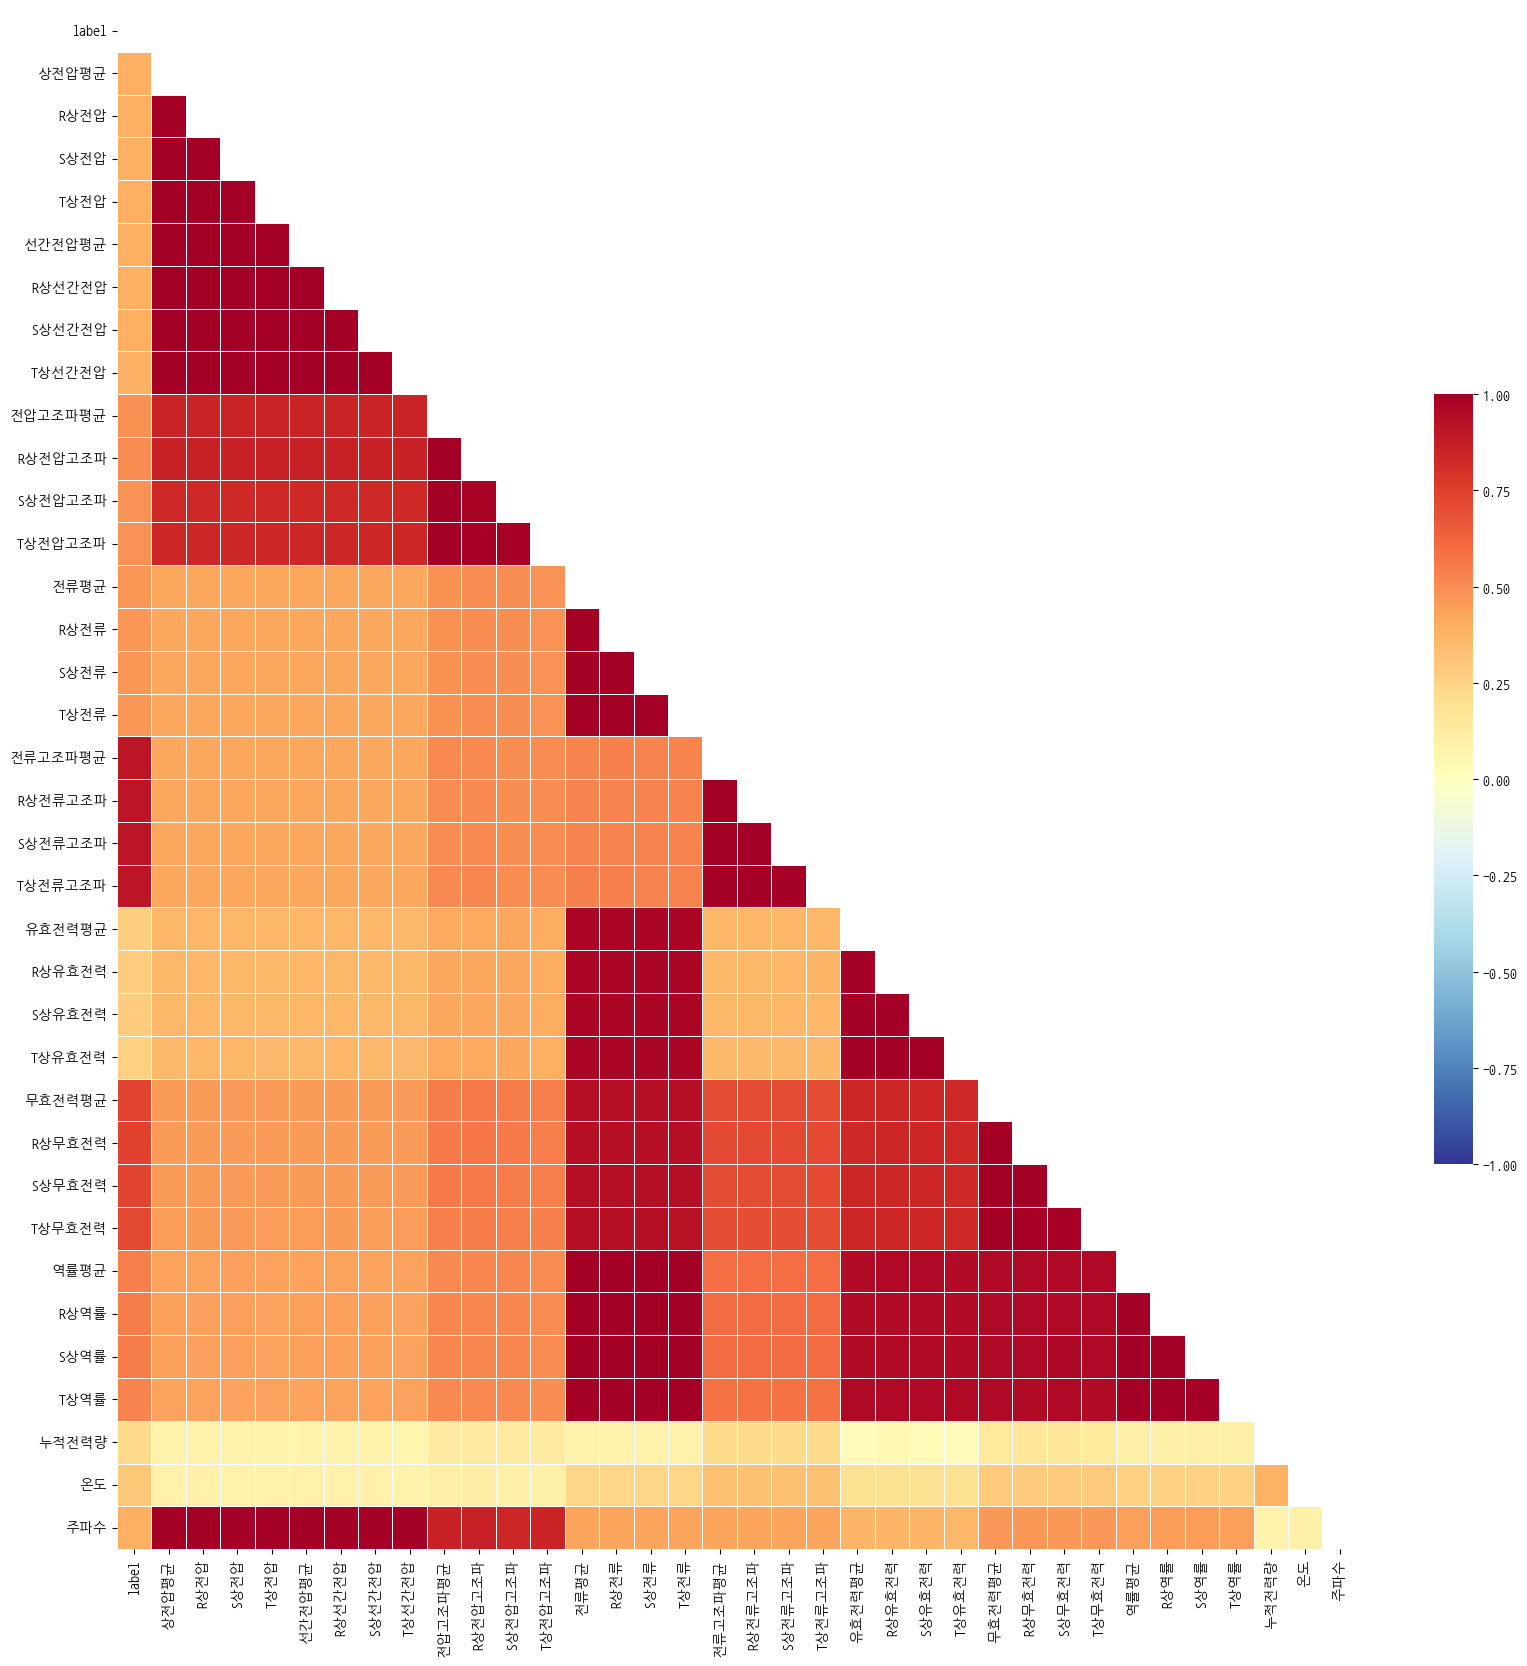

In [9]:
df.loc[df.label == '정상', 'label'] = 0 
df.loc[df.label == '경고', 'label'] = 1
df['label'] = df['label'].astype(int)

test.loc[test.label == '정상', 'label'] = 0 
test.loc[test.label == '경고', 'label'] = 1
test['label'] = test['label'].astype(int)
print(df.label.value_counts())

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df[df.columns[1:]].corr())
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df[df.columns[1:]].corr(), 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

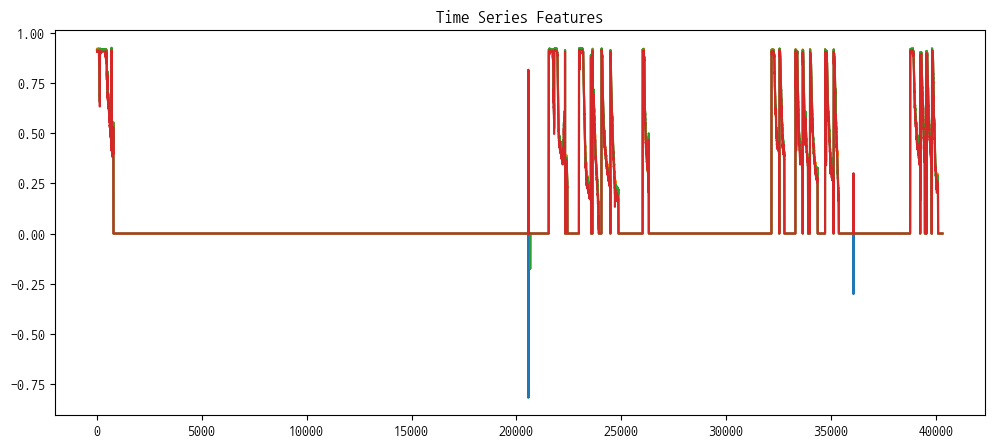

Text(0.5, 1.0, 'Label, Normal - 0, Abnormal - 1')

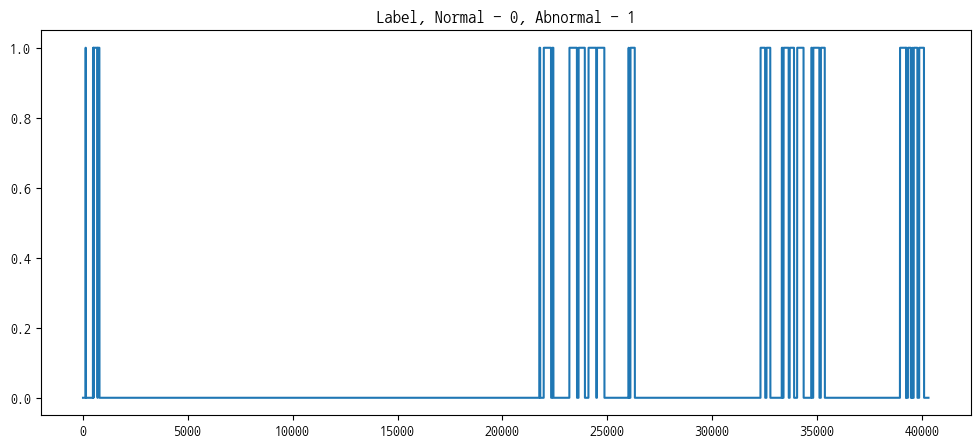

In [10]:
df[powerfactor_cols].plot(figsize=(12,5), legend=False)
plt.title('Time Series Features')
plt.show()
df['label'].plot(figsize=(12,5))
plt.title('Label, Normal - 0, Abnormal - 1')

# `curve_shift` 함수 설명

## 개요
`curve_shift`는 이진 라벨(`label` 열)을 지정한 행 수만큼 이동시킬 수 있는 함수. 주로 이상 징후가 발생하기 전에 **라벨을 이동**시켜 **사전 경고** 시스템을 구현할 때 사용

## 주요 기능
- `shift_by`만큼 라벨을 위(음수) 또는 아래(양수)로 이동.
- 기존의 1로 라벨된 행은 삭제.
- 이동된 라벨은 다시 0 또는 1로 재이진화

## 파라미터
| 이름         | 타입              | 설명 |
|-------------|------------------|------|
| `df`        | `pd.DataFrame`    | 'label' 열이 포함된 시계열 데이터프레임 |
| `shift_by`  | `int`             | 이동할 행 수. 음수는 위로, 양수는 아래로 이동 |

## 반환값
- 라벨이 이동된 새로운 `pd.DataFrame`

## 사용 예시

```python
shifted_df = curve_shift(df, shift_by=-2)

In [11]:
# x 값이 0보다 작으면 -1, 그렇지 않으면 1을 반환하는 람다 함수 
sign = lambda x: (1, -1)[x < 0]

"""
데이터프레임 내의 이진 라벨('y' 열)을 지정된 행 수(shift_by)만큼 위로 이동
 - 라벨이 1로 표시된 행이 있을 경우, 해당 라벨을 shift_by 수만큼 위로 이동시키고, 원래 위치의 행은 삭제. 이 과정은 모든 라벨에 대해 반복
 - 최종적으로 이동된 라벨들이 업데이트된 새로운 데이터프레임을 반환. 함수는 라벨을 이동시킨 후, 이진 라벨을 다시 설정하여 모든 비 0 값을 1로 설정. 라벨의 예측 타이밍을 조정
"""

def curve_shift(df, shift_by):
    """
        데이터프레임에서 이진 라벨 이동, 
         이동은 1(상태이상,파손등)인 라벨을 기준으로 하며, shift가 -2일 경우, n행이 1로 라벨링된다면 (n+shift_by) 부터 (n+shift_by-1)까지의 행을 1로 만들고 n행을 제거 
         최종적으로 라벨은 최대 2행 위로 이동
         
        df       : 'y'라는 이진 라벨(상태 이상, 파손등)과 다변량 시계열 데이터로 이루어진 판다스 데이터프레임
        shift_by : 이동할 행의 수를 나타내는 정수.(1행은 2초를 의미)

    """
    df = df.copy()
    
    vector = df['label'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by)) # 라벨을 shift_by 만큼 이동
        tmp = tmp.fillna(0)                # NaN 값을 0으로 처리 
        vector += tmp
    labelcol = 'label'

    # 벡터를 데이터프레임에 추가
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # 라벨이 1인 행 제거
    df = df.drop(df[df[labelcol] == 1].index)
    # 원래의 라벨 열을 삭제하고 tmp 열의 이름을 라벨 열로 변경
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # 라벨을 이진형으로 변환 
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [12]:
train_X = curve_shift(df, shift_by = -10).reset_index(drop=True)
test_X  = curve_shift(test, shift_by = -10).reset_index(drop=True)

train_X.head()

,label,TIMESTAMP,상전압평균,R상전압,S상전압,T상전압,선간전압평균,R상선간전압,S상선간전압,T상선간전압,...,R상무효전력,S상무효전력,T상무효전력,역률평균,R상역률,S상역률,T상역률,누적전력량,온도,주파수
0,0.0,2021-01-06 00:00:46,228.083328,229.50,228.50,226.25,395.000000,398.00,392.75,394.25,...,11230.0,10986.0,11356.0,0.913558,0.914063,0.914063,0.90625,70482.0859,26.250,59.872740
1,0.0,2021-01-06 00:01:46,227.833328,229.00,228.50,226.00,394.583344,397.75,392.50,393.50,...,11242.0,10964.0,11358.0,0.913602,0.914063,0.914063,0.90625,71747.6500,26.250,59.854076
2,0.0,2021-01-06 00:02:46,227.750000,229.00,228.25,226.00,394.333344,397.50,392.25,393.25,...,11204.0,10992.0,11346.0,0.912992,0.914063,0.914063,0.90625,73008.7900,26.250,59.900776
3,0.0,2021-01-06 00:03:46,227.333328,228.50,228.00,225.50,393.583344,396.75,391.50,392.50,...,11136.0,10922.0,11292.0,0.913531,0.914063,0.914063,0.90625,74266.2000,25.625,59.891422
4,0.0,2021-01-06 00:04:46,227.666672,228.75,228.25,226.00,394.083344,397.00,392.00,393.25,...,11200.0,10978.0,11338.0,0.912952,0.914063,0.914063,0.90625,75523.6600,26.875,59.872740


# `temporalize` 함수 설명

## 개요
`temporalize` 함수는 시계열 데이터에서 **과거 데이터를 기반으로** 일정 기간(lookback)을 기준으로 **특성 배열**과 **타겟 배열**을 변환하여 3차원 배열을 생성하는 함수. 이를 통해 시계열 데이터를 **모델 학습용**으로 적합하게 변환

## 주요 기능
- 주어진 시점에서 과거 `lookback` 기간의 데이터를 수집하여 **3차원 배열**로 변환
- 각 `lookback` 기간 후의 타겟 값 `y`를 포함한 1D 배열 `output_y`도 생성

## 파라미터
| 이름      | 타입             | 설명 |
|----------|-----------------|------|
| `X`      | `np.array` (2D)  | 시간 순으로 정렬된 특성 배열 (관측치 수 x 특성 수) |
| `y`      | `np.array` (1D)  | 타겟 값 배열, 각 `y[i]`는 `X[i]`와 대응 |
| `lookback`| `int`            | 과거 데이터를 조회할 윈도우 크기 (스칼라) |

## 반환값
- `output_X` : 3D 배열 (관측치 수 - `lookback` - 1, `lookback`, 특성 수) 형태
- `output_y` : 1D 배열 (관측치 수 - `lookback` - 1), 타겟 값 배열

## 동작 방식
1. `X`와 `y`를 복사하여 원본 데이터에 영향을 미치지 않도록 지정
2. `lookback` 기간 동안 과거 데이터를 `output_X`에 저장
3. 각 `lookback` 기간에 대한 타겟 값 `y`는 `output_y`에 추가
4. `output_X`는 3D 배열로, `output_y`는 1D 배열로 변환

## 사용 예시

```python
X_temporalized, y_temporalized = temporalize(X, y, lookback=3)

In [13]:
def temporalize(X, y, lookback):
    '''
    각 시점에 대해 과거 lookback 기간 동안의 데이터를 통해 새로운 3차원 배열(output_X) 생성
    output_y는 lookback 기간 후의 y값을 포함
    
    입력:
    X         시간 순으로 정렬된 2D 넘파이 배열, 형태: 
              (관측치 수 x 특성 수)
    y         X와 인덱스가 일치하는 1D 넘파이 배열, 
              즉, y[i]는 X[i]와 대응해야 함. 형태: 관측치 수.
    lookback  과거 기록을 조회할 윈도우 크기. 스칼라 형태.

    출력:
    output_X  3D 넘파이 배열의 형태: 
              ((관측치 수-lookback-1) x lookback x 
              특성 수)
    output_y  1D 배열의 형태: 
              (관측치 수-lookback-1), X와 정렬됨.
    '''
    
    X = X.copy()
    y = y.copy()
    
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # 과거 기록을 lookback 기간 동안 수집
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [15]:
X, y           = temporalize(X = train_X[train_X.columns[2:]].values, y = train_X['label'].values, lookback = 10)
x_test, y_test = temporalize(X = test_X[test_X.columns[2:]].values, y = test_X['label'].values, lookback = 10)

len(X), len(y), len(X[y==0]), len(X[y==1]), len(x_test), len(x_test[y_test==0]), len(x_test[y_test==1])


(35386, 35386, 35116, 270, 3642, 3482, 160)

## 데이터셋 분할 및 셔플

### 1. 데이터 클래스 분리
- `X_0, y_0`: 클래스 0에 해당하는 데이터.
- `X_1, y_1`: 클래스 1에 해당하는 데이터.
- `y == 0`인 데이터는 `X_0`와 `y_0`에, `y == 1`인 데이터는 `X_1`과 `y_1`에 할당하여 각 클래스별로 데이터를 분리

### 2. 훈련 데이터와 검증 데이터 분할
- `train_test_split`을 사용하여 클래스 0의 데이터를 훈련 세트(`x_train`, `y_train`)와 검증 세트(`x_val`, `y_val`)로 분할
- `test_size=0.1`을 설정하여 검증 세트가 전체 데이터의 10%가 되도록 하고, `random_state=seed`를 설정하여 결과가 재현 가능하도록 설정

### 3. 검증 데이터에 클래스 1 추가
- `np.concatenate`를 사용하여 클래스 1 데이터를 검증 세트에 추가
- 이렇게 함으로써, 검증 세트가 클래스 0과 클래스 1의 데이터를 모두 포함

### 4. 검증 데이터 셔플
- `shuffle` 함수를 사용하여 검증 세트(`x_val`, `y_val`)를 섞기
- 이를 통해 데이터의 순서가 모델 학습에 영향을 미치지 않도록 하고, 더 나은 일반화 성능을 얻을 수 있습니다.

### 5. 클래스별 샘플 크기 확인
- 훈련 세트, 검증 세트, 테스트 세트에서 클래스 0과 클래스 1에 해당하는 샘플의 크기를 확인
- 이를 통해 각 클래스별로 균등한 데이터 분포를 보장할 수 있습니다.

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

seed = 99

X_0, y_0 = X[y==0], y[y==0]
X_1, y_1 = X[y==1], y[y==1]

x_train, x_val, y_train, y_val = train_test_split(X_0, y_0, test_size = 0.1, random_state = seed)

x_val = np.concatenate((x_val, X_1))
y_val = np.concatenate((y_val, y_1))

x_val, y_val = shuffle(x_val, y_val, random_state=seed)

x_train[y_train==0].shape, x_train[y_train==1].shape, x_val[y_val==0].shape, x_val[y_val==1].shape, x_test[y_test==0].shape, x_test[y_test==1].shape

((31604, 10, 35),
 (0, 10, 35),
 (3512, 10, 35),
 (270, 10, 35),
 (3482, 10, 35),
 (160, 10, 35))

## 데이터 스케일링 및 차원 변경

### 1. `flatten` 함수
- `flatten` 함수는 주어진 3D 배열 `X`의 데이터를 2D 배열로 **변경**합니다.
- 각 샘플에 대해, 마지막 시간 단계(`X.shape[1]-1`)의 특성 값들을 추출하여 새로운 2D 배열 `flattened_X`를 만듭니다.
  - 입력 데이터는 `(샘플 수, 시간 단계 수, 특성 수)` 형태의 3D 배열입니다.
  - 반환 값은 `(샘플 수, 특성 수)` 형태의 2D 배열입니다.

### 2. `scale` 함수
- `scale` 함수는 `StandardScaler`를 사용하여 데이터를 표준화합니다.
- 각 샘플에 대해, `scaler.transform`을 사용하여 특성 값을 스케일링합니다.
  - `scaler`는 이미 `fit`된 `StandardScaler` 객체로, 각 샘플의 특성을 개별적으로 표준화합니다.

### 3. `StandardScaler`를 이용한 데이터 표준화
- `StandardScaler` 객체는 데이터의 평균을 0, 표준편차를 1로 조정하여 각 특성을 표준화합니다.
- `flatten(x_train)`을 사용하여 훈련 데이터 `x_train`을 2D 배열로 변환하고, 이를 기반으로 `scaler`를 학습시킵니다.

### 4. 표준화된 데이터 생성
- `x_train_scaled`, `x_valid_scaled`, `x_valid_y0_scaled`, `x_test_scaled`: `scale` 함수를 사용하여 훈련 데이터, 검증 데이터, 클래스 0의 검증 데이터, 테스트 데이터에 대해 표준화를 수행합니다.
  - 훈련 데이터와 검증 데이터, 테스트 데이터는 `scaler`를 이용해 개별적으로 표준화됩니다.
  - 클래스 0에 해당하는 검증 데이터는 별도로 표준화하여 `x_valid_y0_scaled`에 저장됩니다.

In [279]:
from sklearn.preprocessing import StandardScaler

def flatten(X):
    X = X.copy()
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)
def scale(X, scaler):
    X = X.copy()
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

scaler = StandardScaler().fit(flatten(x_train))

x_train_scaled    = scale(x_train, scaler)
x_valid_scaled    = scale(x_val, scaler)
x_valid_y0_scaled = scale(x_val[y_val==0], scaler)
x_test_scaled     = scale(x_test, scaler)

In [280]:
x_train_scaled.max(), x_train_scaled.min()

(18.46880401991652, -43.63253457104911)

In [281]:
x_valid_y0_scaled.max(), x_valid_y0_scaled.min()

(13.411380408117974, -43.63253457104911)

In [282]:
x_test_scaled.max(), x_test_scaled.min()

(21.23455182999588, -4.354830046853243)

## LSTM Autoencoder 모델 구축

이 코드는 시계열 데이터를 처리하는 **LSTM Autoencoder** 모델을 정의합니다. 해당 모델은 주로 이상 탐지, 데이터 압축, 또는 시계열 데이터의 특성 학습을 위해 사용됩니다. 모델의 구성 요소를 단계별로 설명합니다.

### 1. 데이터 처리
- `timesteps`: 입력 데이터에서 시간 단계 수를 설정합니다. 이는 `x_train_scaled.shape[1]`로 정의됩니다.
- `n_features`: 특성 수를 설정합니다. 이는 `x_train_scaled.shape[2]`로 정의됩니다.

### 2. 하이퍼파라미터 설정
- `epochs`: 모델 학습의 에포크 수를 설정합니다. 여기서는 250번으로 설정되어 있습니다.
- `batch`: 배치 크기를 64로 설정합니다.
- `lr`: 학습률을 0.0001로 설정합니다.

### 3. 모델 구조

#### 3.1. **입력 레이어 (Input Layer)**
- `Input(shape=(timesteps, n_features))`: 이 레이어는 시계열 데이터의 입력을 받습니다. `timesteps`는 시간 단계의 수, `n_features`는 각 시간 단계의 특성 수입니다.

#### 3.2. **Encoder (인코더)**
- `encoder_lstm_1`: 첫 번째 LSTM 레이어로, 128개의 유닛을 사용하고 `return_sequences=True`로 설정되어 있습니다. 이는 시계열 데이터를 계속해서 처리할 수 있도록 이전 시점의 정보를 다음 시점에 전달합니다. `dropout=0.3`으로 일부 유닛을 드롭하여 과적합을 방지합니다.
- `encoder_lstm_2`: 두 번째 LSTM 레이어로, 64개의 유닛을 사용하며 `return_sequences=False`로 설정되어 있어, 마지막 출력만 반환합니다.

#### 3.3. **RepeatVector (반복 벡터)**
- `RepeatVector(timesteps)`: 인코더의 마지막 숨겨진 상태를 `timesteps` 만큼 반복하여, 디코더가 여러 시간 단계에 대해 동일한 입력을 받을 수 있게 만듭니다.

#### 3.4. **Decoder (디코더)**
- `decoder_lstm_1`: 첫 번째 디코더 LSTM 레이어로, 64개의 유닛을 사용하고 `return_sequences=True`로 설정되어 있어, 시계열 데이터를 다시 처리할 수 있습니다.
- `decoder_lstm_2`: 두 번째 디코더 LSTM 레이어로, 128개의 유닛을 사용하며 `return_sequences=True`로 설정되어 있습니다.

#### 3.5. **Multi-Head Attention (멀티 헤드 어텐션)**
- `MultiHeadAttention(num_heads=4, key_dim=64)`: 4개의 헤드를 가지는 멀티 헤드 어텐션 레이어입니다. 이 레이어는 디코더의 출력을 인코더의 출력과 비교하여 더 중요한 정보를 강조합니다.
- `decoder_attention_output`: 멀티 헤드 어텐션 레이어는 `decoder_lstm_2`의 출력을 쿼리로, `encoder_lstm_1`의 출력을 값으로 사용하여 정보를 처리합니다.

#### 3.6. **출력 레이어 (Output Layer)**
- `TimeDistributed(Dense(n_features, activation='linear'))`: 이 레이어는 각 시간 단계마다 `n_features` 차원의 출력을 생성합니다. `activation='linear'`는 회귀 문제에서 사용하는 출력 활성화 함수입니다. 각 시간 단계에 대해 예측값을 출력합니다.

### 4. 모델 요약
- 모델의 전체 아키텍처는 인코더-디코더 구조로, 시계열 데이터의 특성을 학습하고 이를 복원하는 방식으로 작동합니다.
- `lstm_autoencoder.summary()`는 모델의 구조와 각 레이어의 파라미터 수를 출력합니다.

### 5. 모델 컴파일 및 학습
- 모델을 컴파일하고 학습하는 코드는 포함되어 있지 않지만, 모델을 학습하기 전에 적절한 손실 함수 및 최적화 알고리즘을 설정해야 합니다. 예를 들어, 회귀 문제의 경우 `mean_squared_error` 손실 함수를 사용할 수 있습니다.

In [ ]:
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Attention, Input, Dropout, MultiHeadAttention
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

timesteps  =  x_train_scaled.shape[1]  # lookback
n_features =  x_train_scaled.shape[2] # 59

epochs = 250
batch = 64
lr = 0.0001

input_layer = Input(shape=(timesteps, n_features))
# Encoder
encoder_lstm_1         = LSTM(128, activation='tanh', return_sequences=True, dropout=0.3)(input_layer)
# encoder_lstm_1_dropout = Dropout(0.2)(encoder_lstm_1)
encoder_lstm_2         = LSTM(64, activation='tanh', return_sequences=False, dropout=0.3)(encoder_lstm_1)  
# encoder_lstm_2_dropout = Dropout(0.2)(encoder_lstm_2)
# RepeatVector
repeat_vector = RepeatVector(timesteps)(encoder_lstm_2)  # Repeat the last hidden state across timesteps
# Decoder
decoder_lstm_1         = LSTM(64, activation='tanh', return_sequences=True, dropout=0.3)(repeat_vector)
# decoder_lstm_1_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_lstm_2         = LSTM(128, activation='tanh', return_sequences=True, dropout=0.3)(decoder_lstm_1)
# decoder_lstm_2_dropout = Dropout(0.2)(decoder_lstm_2)
# Attention Layer
# decoder_attention_output = Attention()([encoder_lstm_1, decoder_lstm_2_dropout])
# decoder_attention_output = Attention()([decoder_lstm_2, encoder_lstm_1])

from tensorflow.keras.layers import Add, LayerNormalization

# Multi-Head Attention
multihead_attention = MultiHeadAttention(num_heads=4, key_dim=64)
decoder_attention_output = multihead_attention(query=decoder_lstm_2, value=encoder_lstm_1)


output_layer = TimeDistributed(Dense(n_features, activation='linear'))(decoder_attention_output)

# 모델 생성
lstm_autoencoder = Model(inputs=input_layer, outputs=output_layer)
lstm_autoencoder.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 10, 35)]             0         []                            
                                                                                                  
 lstm_60 (LSTM)              (None, 10, 128)              83968     ['input_46[0][0]']            
                                                                                                  
 lstm_61 (LSTM)              (None, 64)                   49408     ['lstm_60[0][0]']             
                                                                                                  
 repeat_vector_29 (RepeatVe  (None, 10, 64)               0         ['lstm_61[0][0]']             
 ctor)                                                                                     

In [297]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

# cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
#                                save_best_only=True,
#                                verbose=0)

# tb = TensorBoard(log_dir='./logs',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(x_train_scaled, x_train_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(x_valid_y0_scaled, x_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/250
494/494 - 5s - loss: 0.1496 - val_loss: 0.0272 - 5s/epoch - 10ms/step
Epoch 2/250
494/494 - 2s - loss: 0.0259 - val_loss: 0.0201 - 2s/epoch - 4ms/step
Epoch 3/250
494/494 - 2s - loss: 0.0236 - val_loss: 0.0181 - 2s/epoch - 4ms/step
Epoch 4/250
494/494 - 2s - loss: 0.0213 - val_loss: 0.0155 - 2s/epoch - 4ms/step
Epoch 5/250
494/494 - 2s - loss: 0.0189 - val_loss: 0.0145 - 2s/epoch - 4ms/step
Epoch 6/250
494/494 - 2s - loss: 0.0174 - val_loss: 0.0129 - 2s/epoch - 4ms/step
Epoch 7/250
494/494 - 2s - loss: 0.0164 - val_loss: 0.0125 - 2s/epoch - 4ms/step
Epoch 8/250
494/494 - 2s - loss: 0.0155 - val_loss: 0.0123 - 2s/epoch - 4ms/step
Epoch 9/250
494/494 - 2s - loss: 0.0151 - val_loss: 0.0113 - 2s/epoch - 4ms/step
Epoch 10/250
494/494 - 2s - loss: 0.0145 - val_loss: 0.0110 - 2s/epoch - 4ms/step
Epoch 11/250
494/494 - 2s - loss: 0.0141 - val_loss: 0.0107 - 2s/epoch - 4ms/step
Epoch 12/250
494/494 - 2s - loss: 0.0139 - val_loss: 0.0102 - 2s/epoch - 4ms/step
Epoch 13/250
494/494 - 2

## 모델 학습 과정 시각화

이 코드는 LSTM Autoencoder 모델의 학습 과정에서 발생한 **손실(loss)** 값의 변화를 시각화하는 코드입니다. 훈련 데이터와 검증 데이터에 대한 손실 값을 그래프로 나타냅니다.


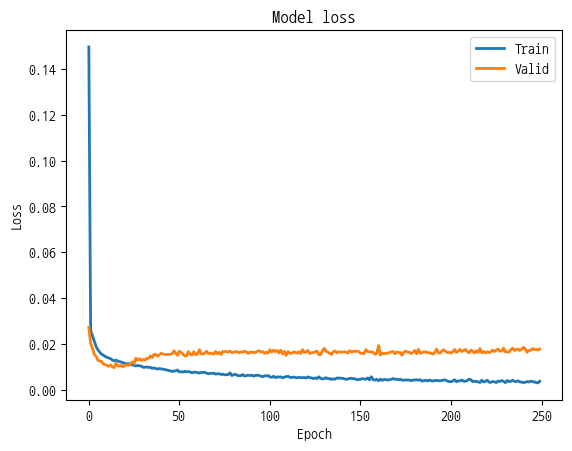

In [298]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 모델 성능 평가: 정밀도, 재현율 및 최적 임계값 선정

이 코드는 LSTM Autoencoder 모델의 예측 결과를 바탕으로 **정밀도(Precision)**, **재현율(Recall)**, **F1 스코어** 등을 계산하고, 최적의 **임계값(threshold)**을 선택하는 과정입니다. 또한, 임계값에 따른 정밀도와 재현율의 변화를 시각화합니다.

119/119 [==============================] - 0s 2ms/step
[0.15805481]


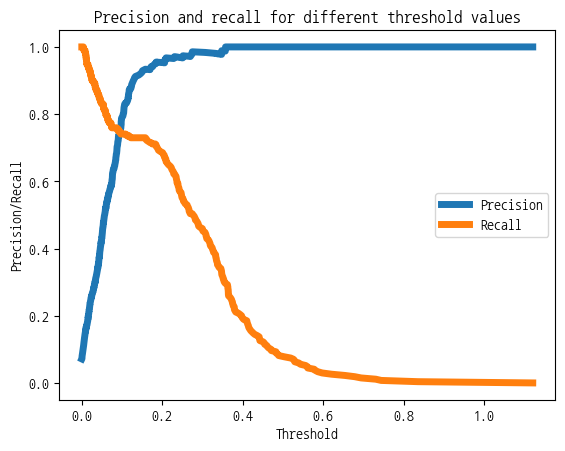

In [315]:
from sklearn.metrics import average_precision_score

valid_x_predictions = lstm_autoencoder.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)
# mse = np.mean(np.power(x_valid_scaled.mean(axis=1) - valid_x_predictions.mean(axis=1), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
f1_score = 2 * precision_rt * recall_rt / (precision_rt + recall_rt)
average_precision = average_precision_score(error_df.True_class, error_df.Reconstruction_error)

# Choosing the threshold to maximize the F1 score
max_f1 = f1_score[f1_score == max(f1_score)]
best_threshold = threshold_rt[f1_score[1: ] == max_f1]
print(best_threshold)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## 재구성 오류 시각화 및 임계값 표시

이 코드는 모델이 예측한 **재구성 오류(Reconstruction Error)** 값들을 시각화하고, **최적 임계값**을 기준으로 각 데이터 포인트의 오류를 비교합니다. 정상 데이터와 이상 데이터의 재구성 오류를 구분하여 시각적으로 확인할 수 있습니다.


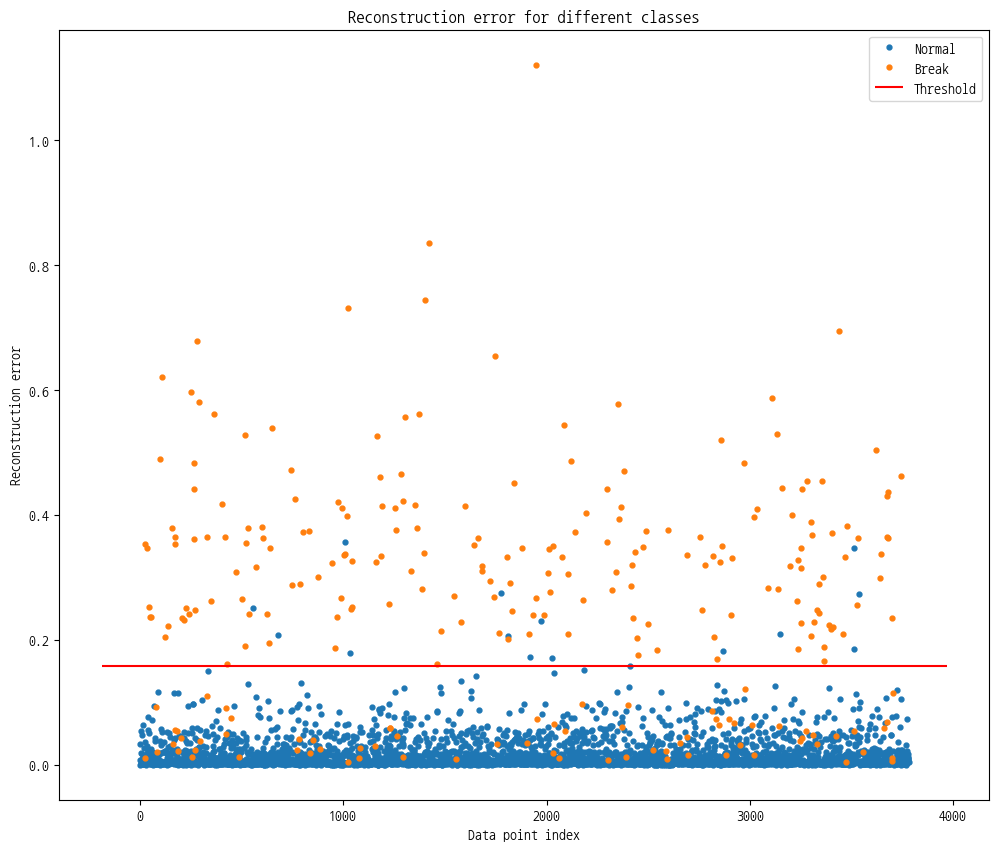

In [316]:
threshold_fixed = best_threshold
groups  = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(12,10))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## 혼동 행렬 시각화

이 코드는 모델의 예측 결과를 **혼동 행렬(confusion matrix)**로 시각화하여, 모델의 **정확도**와 **오류**를 명확히 확인할 수 있도록 합니다. 혼동 행렬은 실제 클래스와 예측 클래스 간의 관계를 시각적으로 나타냅니다.


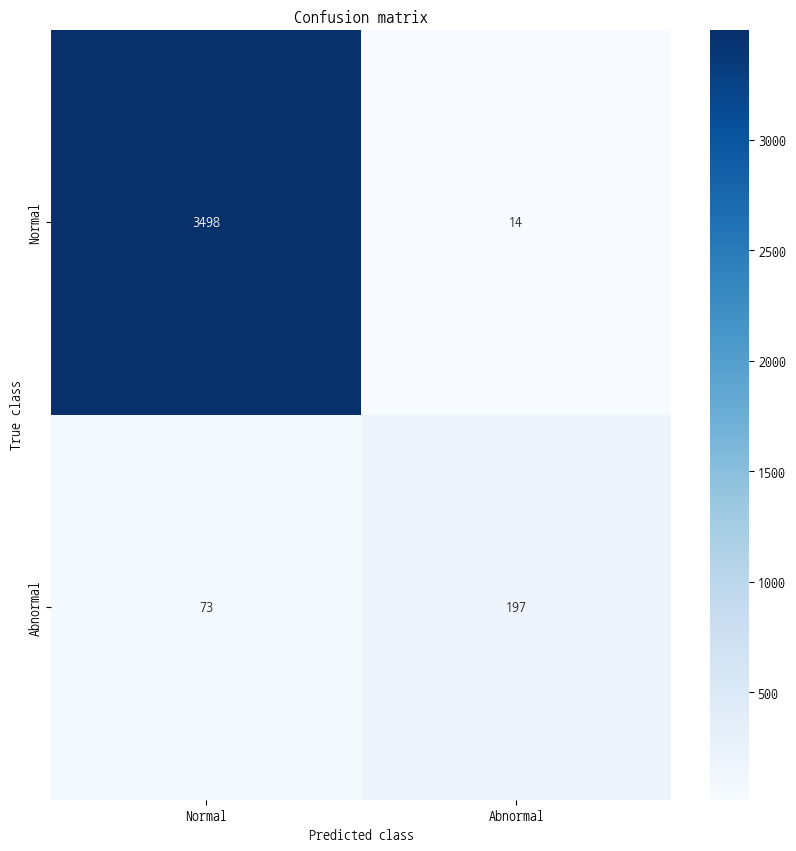

In [317]:
LABELS = ['Normal', 'Abnormal']

pred_y = [1 if e > best_threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Precision, Recall Curve & F1 Score Curve

이 코드는 **Precision**, **Recall**, **F1 Score**를 **threshold** 값에 대해 시각화하여 모델 성능을 평가하는 데 사용됩니다. 이 그래프들은 모델의 예측 성능을 **threshold**에 따라 어떻게 변화하는지 보여줍니다.


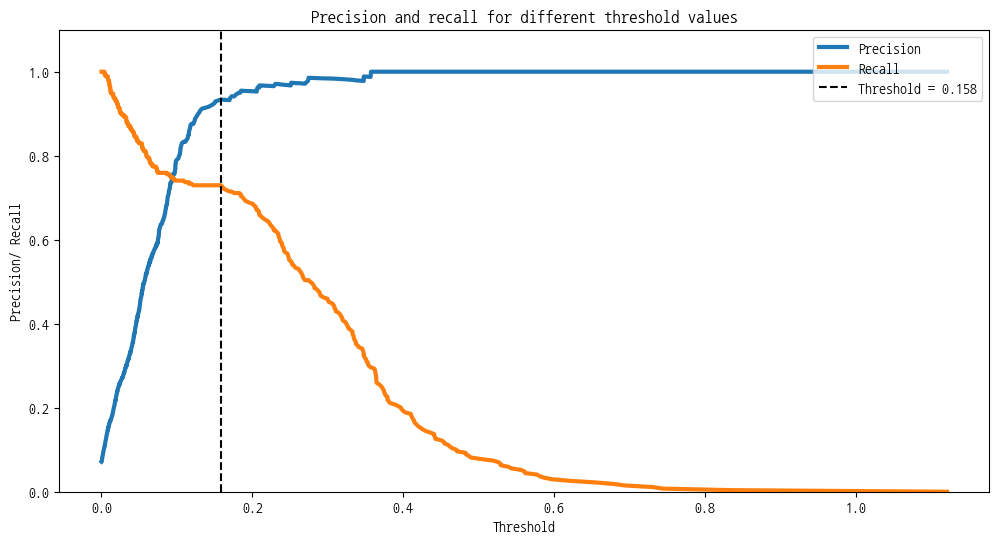

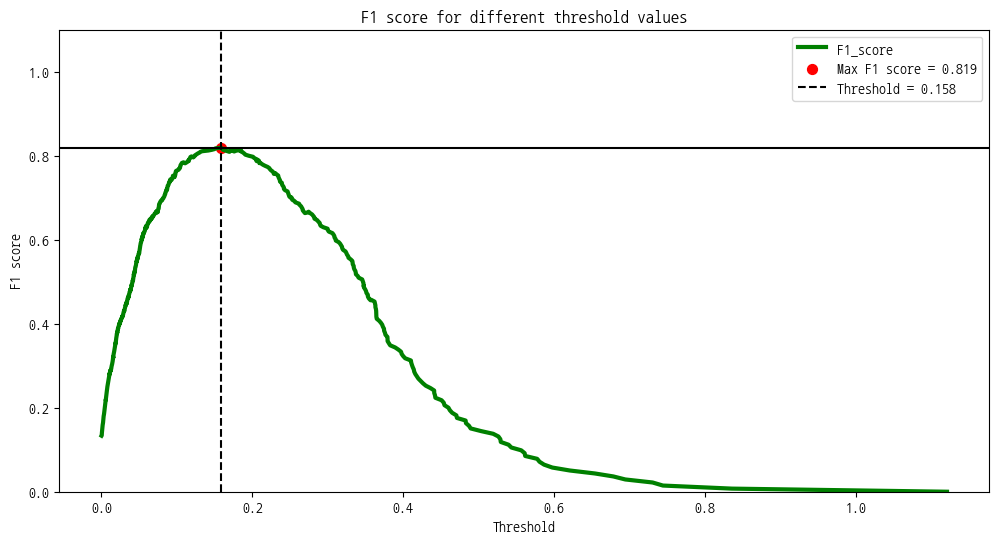

Best threshold = 0.158055
Max F1 score = 0.819127


In [318]:
## Precision, Recall curve 
plt.figure(figsize = (12, 6))
plt.plot(threshold_rt, precision_rt[1: ], label = "Precision", linewidth = 3)
plt.plot(threshold_rt, recall_rt[1: ], label ="Recall", linewidth = 3)
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall')
plt.title('Precision and recall for different threshold values')
plt.legend(loc = 'upper right')

## F1 score curve
plt.figure(figsize = (12, 6))
plt.plot(threshold_rt, f1_score[1: ], label = "F1_score", linewidth = 3, color = 'green')
plt.scatter(threshold_rt[f1_score[1: ] == max_f1], max_f1, label = 'Max F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.axhline(max_f1, color = 'black', ls = '-')
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 score for different threshold values')
plt.legend(loc = 'upper right')

plt.show()
print('Best threshold = %f' % (best_threshold))
print('Max F1 score = %f' % (max_f1))

In [303]:
x_test_scaled.mean(axis=1).shape

(3642, 35)

## 모델 예측 및 재구성 오류 분석

이 코드는 **LSTM Autoencoder** 모델을 사용하여 **Test Data**에 대해 예측을 수행하고, **재구성 오류**(Reconstruction Error)를 계산하여 **Normal**과 **Abnormal** 클래스에 대해 시각화합니다. 또한, 최적의 **threshold**를 사용하여 예측 결과를 평가합니다.


114/114 [==============================] - 0s 2ms/step


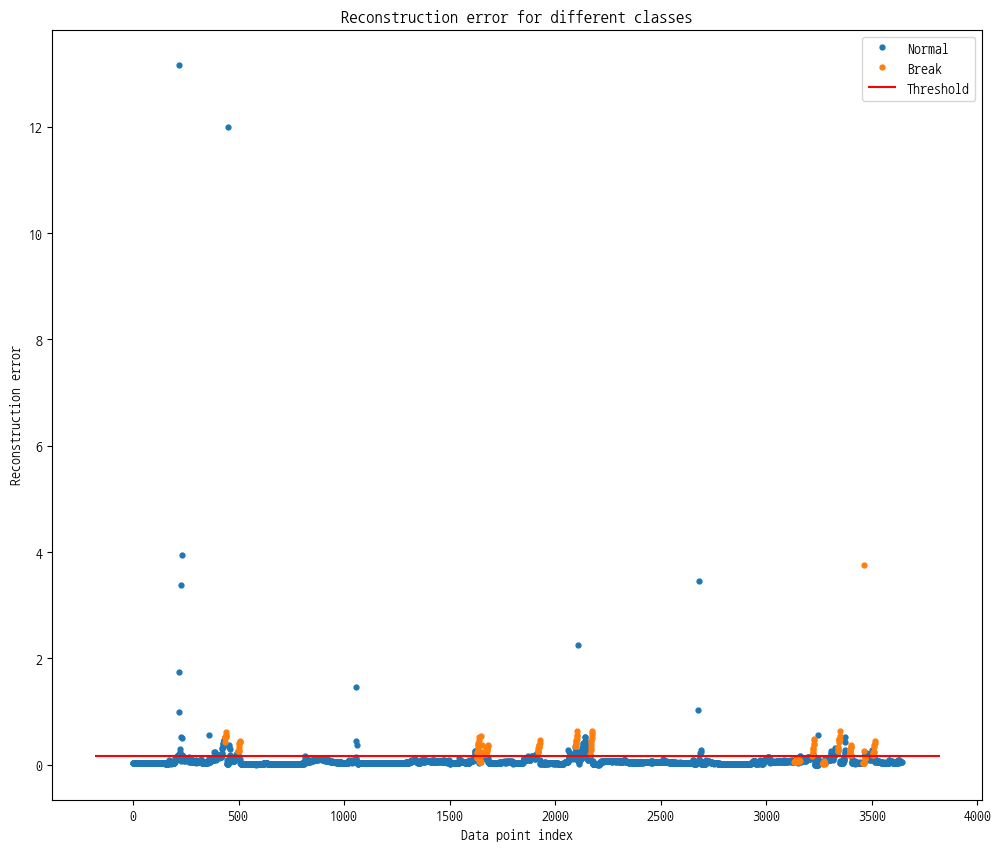

In [319]:
test_x_predictions = lstm_autoencoder.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)
# mse = np.mean(np.power(x_test_scaled.mean(axis=1) - test_x_predictions.mean(axis=1), 2), axis=1)
# mse = np.mean(np.power(x_test_scaled[:,-1,:] - test_x_predictions[:,-1,:], 2), axis=1)


error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = best_threshold
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(12,10))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Confusion Matrix

이 코드는 **Confusion Matrix**를 시각화하여, 모델의 **정확도**(Accuracy) 및 **성능**을 평가합니다. **재구성 오류**(Reconstruction Error)를 기반으로 예측된 클래스와 실제 클래스를 비교하고, 이 비교 결과를 **Confusion Matrix**로 표시합니다.


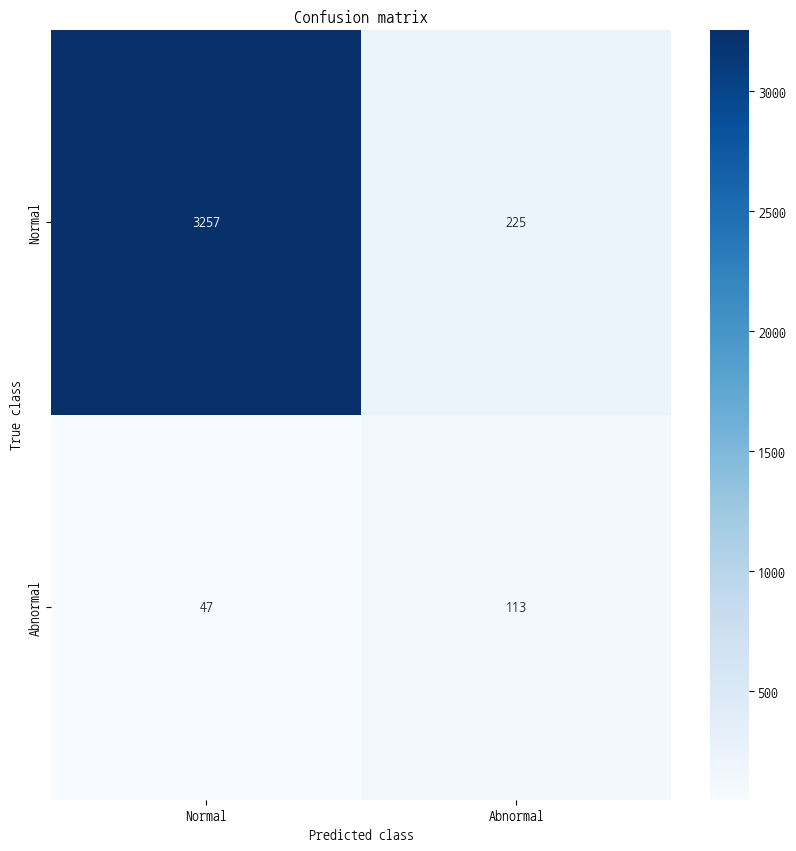

In [320]:
LABELS = ['Normal', 'Abnormal']

pred_y = [1 if e > best_threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## ROC Curve 및 AUC (Receiver Operating Characteristic Curve and Area Under the Curve)

이 코드는 **ROC Curve**와 **AUC**를 시각화하여 모델의 **이진 분류 성능**을 평가합니다. **재구성 오류**(Reconstruction Error)를 기준으로 **진양성율(True Positive Rate)**과 **위양성율(False Positive Rate)**을 계산하고, 이를 **ROC Curve**로 시각화하여 모델의 **성능**을 평가합니다.


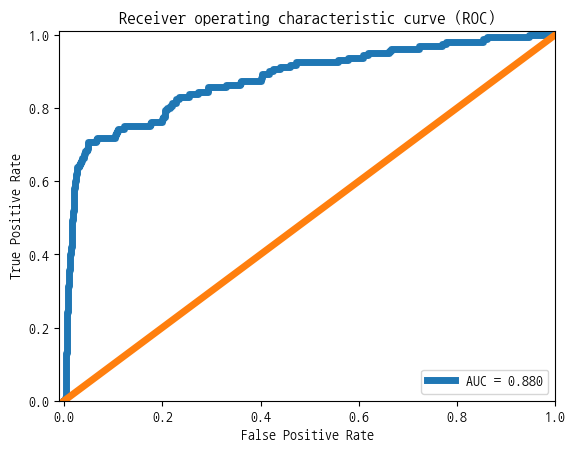

In [321]:
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 모델 평가 지표 출력

이 코드는 모델의 예측 성능을 다양한 **평가 지표**를 통해 계산하고 출력합니다. 주요 평가 지표로는 **정확도(Accuracy)**, **재현율(Recall)**, **정밀도(Precision)**, **F1 점수(F1 Score)**, **AUC(ROC-AUC)** 등이 포함됩니다. 각 지표의 정의와 함께 계산 방법을 설명합니다.


In [322]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# 실제 값과 예측 값을 이용해 혼동 행렬 생성
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
tn, fp, fn, tp = conf_matrix.ravel()

# 정확도 (Accuracy)
accuracy = accuracy_score(error_df.True_class, pred_y)

# 민감도 (Sensitivity) == 재현율 (Recall)
sensitivity = recall_score(error_df.True_class, pred_y)

# 특이도 (Specificity)
specificity = tn / (tn + fp)

# 정밀도 (Precision)
precision = precision_score(error_df.True_class.values, pred_y)

# F1 점수 (F1 Score)
f1 = f1_score(error_df.True_class.values, pred_y)

# AUC (ROC-AUC 점수)
auc = roc_auc_score(error_df.True_class, error_df.Reconstruction_error.values)

# 결과 출력
print(f"Accuracy             : {accuracy:.3f}")
print(f"Sensitivity (Recall) : {sensitivity:.3f}")
print(f"Specificity          : {specificity:.3f}")
print(f"AUC                  : {auc:.3f}")

Accuracy             : 0.925
Sensitivity (Recall) : 0.706
Specificity          : 0.935
AUC                  : 0.880


## ONNX로 변환된 모델과 Keras 모델의 예측 결과 비교

이 코드는 TensorFlow에서 학습된 **LSTM Autoencoder** 모델을 **ONNX** 형식으로 변환하고, 변환된 모델과 원래 Keras 모델을 비교하는 과정입니다. 두 모델을 비교하여 **예측 결과**와 **성능**이 일치하는지 확인합니다.

onnx 변환이 실제 예측에 미치지 않을 정도로 잘 경량화 되었음

2025-04-26 16:59:38.617206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 16:59:38.617330: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-26 16:59:38.617381: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-26 16:59:38.617623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 16:59:38.617724: I tensorflow/compiler/xla/stream_executor/

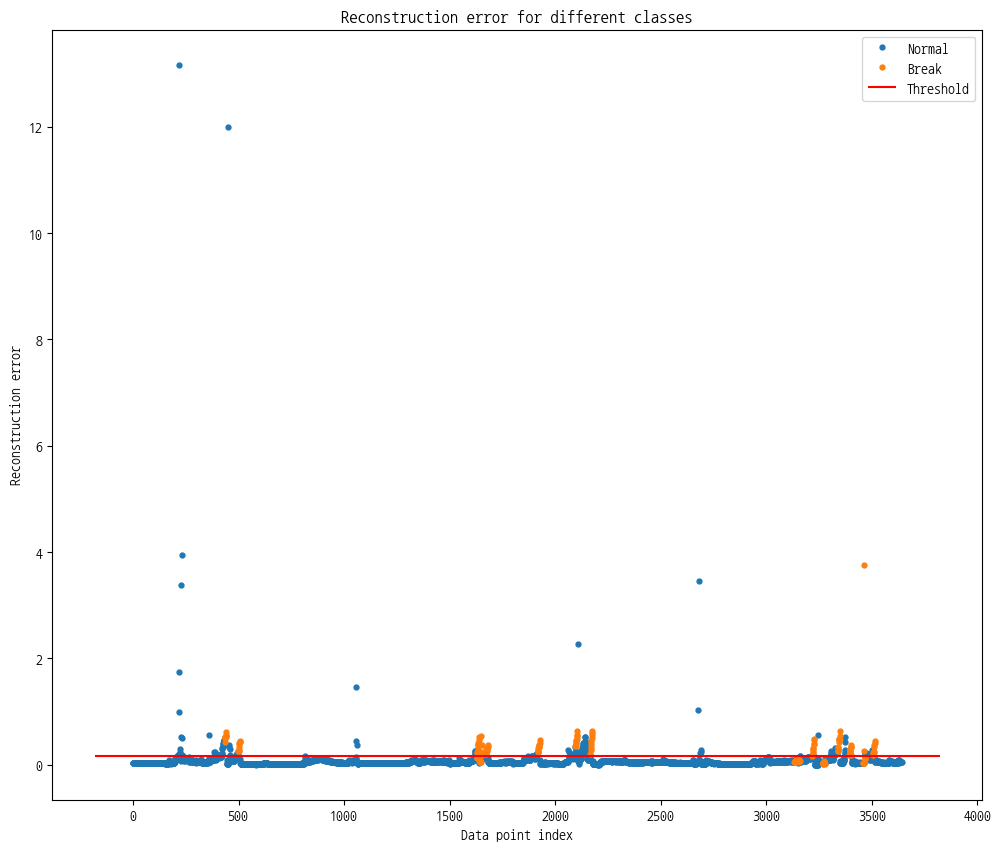

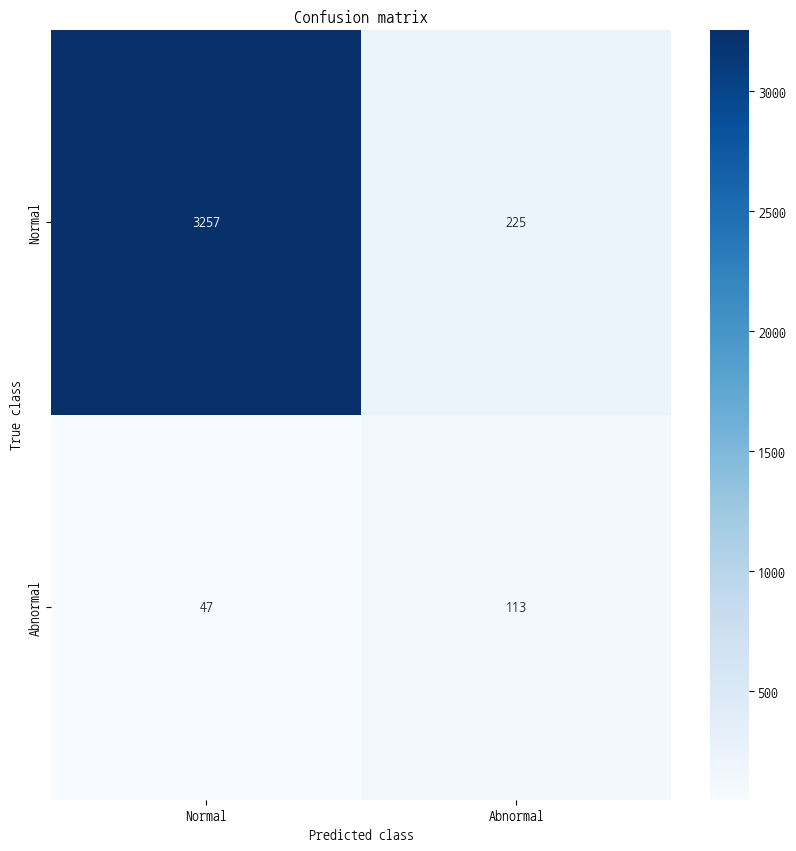

In [334]:
import tf2onnx

# 모델을 ONNX로 변환
spec = (tf.TensorSpec((None, timesteps, n_features), tf.float32, name="input"),)
output_path = "model/lstm_autoencoder.onnx"

model_proto, _ = tf2onnx.convert.from_keras(lstm_autoencoder, input_signature=spec, opset=13, output_path=output_path)

import onnxruntime as ort

# ONNX 모델 로드
session = ort.InferenceSession("model/lstm_autoencoder.onnx", providers=['CPUExecutionProvider'])

# 예측할 입력 데이터 준비
# 예시: X_test.shape == (batch_size, timesteps, n_features)
input_name = session.get_inputs()[0].name

# 예측 수행
onnx_pred = session.run(None, {input_name: x_test_scaled.astype(np.float32)})

# 출력 결과
predicted_output = onnx_pred[0]


mse = np.mean(np.power(flatten(x_test_scaled) - flatten(predicted_output), 2), axis=1)
# mse = np.mean(np.power(x_test_scaled.mean(axis=1) - test_x_predictions.mean(axis=1), 2), axis=1)
# mse = np.mean(np.power(x_test_scaled[:,-1,:] - test_x_predictions[:,-1,:], 2), axis=1)


error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = best_threshold
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(12,10))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


LABELS = ['Normal', 'Abnormal']

pred_y = [1 if e > best_threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## 모델 스케일러와 최적 임계값 저장

이 코드는 **모델의 스케일러**와 **최적 임계값(best_threshold)** 을 **joblib** 라이브러리를 사용하여 저장하는 과정입니다. 이를 통해, 학습된 모델의 변환 및 예측을 실행할 때 동일한 스케일링 방법과 임계값을 적용할 수 있도록 합니다.


In [331]:
import joblib

joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(best_threshold, 'model/threshold.pkl')

['model/threshold.pkl']